In [4]:
from scipy import integrate
import matplotlib.pyplot as plt
import os
import numpy as np
from matplotlib import pyplot as plt      
import pandas as pd
from scipy import special                 
import array
import scipy as sp
import scipy.interpolate
import re
import pickle as pickle
def unPackRawFile(raw_path):
    """


    
    - unpacks the .raw file. Not used for the neural network.
    """
    y = np.loadtxt(raw_path, skiprows=6)
    distance = y[:,0]
    pec_vel = y[:,1]
    temp = y[:,2]
    HI_density = y[:,3]
    gas_density = y[:,4]
    gas_metallicity = y[:,5]
   
    return distance, pec_vel, temp, HI_density, gas_density, gas_metallicity

def getPos(path_LOS,linenumber=8):
    """
    the start position of the LOS is given inside each file, (in the comments)
    this function parses the comments to get that information
    """
    f = open(path_LOS)
    x = f.readlines()[linenumber]
    answer = re.search('\(([^)]+)', x).group(1)
    arr = np.array(answer.split(','),dtype=float)
    return arr

def getDir(path_LOS,linenumber=8):
    """
    the direction of the LOS is given inside each file, (in the comments)
    this function parses the comments to get that information
    """
    f = open(path_LOS)
    x = f.readlines()[linenumber]
    answer = re.search('\(([^)]+)', x.split(', ')[1]).group(1)
    arr = np.array(answer.split(','),dtype=float)
    return arr


def convertSphereToCart(theta, phi):
    "converts a unit vector in spherical to cartesian, needed for getGalaxies"
    return np.array([np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)])

def calculate_gamma(temperature,density,xHI,scale):
    '''Gamma = R(T)*ne/xHI, R(T) = 4.3e-13 * (T/1e4K)^{-0.7), ne = 0.82*nb.
    '''
    omega_b = 0.0479; h = 0.6814
    mean_nb = 1.123e-5/scale**3*omega_b*h**2
    nb = np.multiply(density ,mean_nb); ne = 0.82*nb
    R_T = 4.3e-13 * (np.divide(temperature,1e4))**(-0.7)
    gamma = R_T * ne / xHI
    
def lyman_identification():
    """
    function for identifying lls using neutral fraction as filter
    """
    neutral_fraction_limit = 1e-3
    
    neutral_fraction = []
    real_lyman = []
    gamma = []
    HI = []
    gas_den = []
    real_area_under = []
    which = []
    
    for i in range(1000):
        raw_path = 'los.00' + '{0:03}'.format(i) +'.raw'
        distance, pec_vel, temp, HI_density, gas_density, gas_metallicity = unPackRawFile(raw_path)
        #changing the distance from chimp to cemeters
        factor = 0.1453*3.086e24 /0.68
        distance_cm = distance *factor
        position = getPos(raw_path)
        direction = convertSphereToCart(getDir(raw_path)[0],getDir(raw_path)[1])
        for k in range(len(distance) -2):
            """check if the continuing measurement is higher than the neutral fraction limit"""
            if(HI_density[k]/gas_density[k]<neutral_fraction_limit and HI_density[k+1]/gas_density[k+1]>neutral_fraction_limit):
                left_bases = k +1
                peak_fraction = HI_density[k]/gas_density[k]
                peak_HI = HI_density[k]
                peak_distance = distance[k]
                peak_gas = gas_density[k]
                if( k+1 <len(distance)):
                    while(not(HI_density[k]/gas_density[k]>neutral_fraction_limit and HI_density[k+1]/gas_density[k+1]<neutral_fraction_limit) and k <len(distance)-2):
                        right_bases = k +1
                        if(k<len(distance)-1):
                            k+=1
                        if(HI_density[k]/gas_density[k]>peak_fraction):
                            peak_fraction = HI_density[k]/gas_density[k]
                            peak_HI = HI_density[k]
                            peak_distance = distance[k]
                            peak_gas = gas_density[k]
                            peak_gamma = calculate_gamma(temp[k],gas_density[k],peak_fraction,0.1452)
                    area_under = peak_HI *1/2*(distance_cm[right_bases]-distance_cm[left_bases])/0.937415
                    real_distance = [(position[0]/256*40+peak_distance*direction[0])%40, (position[1]/256*40+peak_distance*direction[1])%40,(position[2]/256*40+peak_distance*direction[2])%40]
                    distance_graph = []
                    HI_graph = [ ]
                    distance_real = []
                    for i in range(len(distance)):
                        if(distance[left_bases]<=distance[i]<= distance[right_bases]):
                            distance_graph.append(distance_cm[i])
                            HI_graph.append(HI_density[i])
                            distance_real.append(distance[i])
                    y_int = integrate.cumtrapz(HI_graph,distance_graph,initial = 0)
                    area_under = peak_HI *1/2*(distance_cm[right_bases]-distance_cm[left_bases])/0.937415
                    if(y_int[-1] >= (1.6e16)and y_int[-1]  <= (10**22)):
                        real_lyman.append([y_int,real_distance])
                        real_area_under.append(y_int)
                        neutral_fraction.append(peak_fraction)
                        HI.append(peak_HI)
                        gamma.append(peak_gamma)
                        gas_den.append(peak_gas)
                        which.append([i,distance[left_bases], distance[right_bases], peak_distance])
    return real_lyman,neutral_fraction,gamma,HI,gas_den,which,real_area_under

In [5]:
import numpy as np
real_lyman,neutral_fraction,gamma,HI,gas_den,which,real_area_under  = lyman_identification()

In [25]:
        neutral_fraction_limit = 1e-3       
        raw_path = 'los.00' + '{0:03}'.format(0) +'.raw'
        distance, pec_vel, temp, HI_density, gas_density, gas_metallicity = unPackRawFile(raw_path)
        #changing the distance from chimp to cmeters
        factor = 0.1453*3.086e24 /0.68
        distance_cm = distance *factor
        position = getPos(raw_path)
        direction = convertSphereToCart(getDir(raw_path)[0],getDir(raw_path)[1])
        for k in range(len(distance) -2):
            if(HI_density[k]/gas_density[k]<neutral_fraction_limit and HI_density[k+1]/gas_density[k+1]>neutral_fraction_limit):
                left_bases = k +1
                peak_fraction = HI_density[k]/gas_density[k]
                peak_HI = HI_density[k]
                peak_distance = distance[k]
                peak_gas = gas_density[k]
                if( k+1 <len(distance)):
                    while(not(HI_density[k]/gas_density[k]>neutral_fraction_limit and HI_density[k+1]/gas_density[k+1]<neutral_fraction_limit) and k <len(distance)-2):
                        right_bases = k +1
                        if(k<len(distance)-1):
                            k+=1
                        if(HI_density[k]/gas_density[k]>peak_fraction):
                            peak_fraction = HI_density[k]/gas_density[k]
                            peak_HI = HI_density[k]
                            peak_distance = distance[k]
                            peak_gas = gas_density[k]
                            peak_gamma = calculate_gamma(temp[k],gas_density[k],peak_fraction,0.1452)
                    area_under = peak_HI *1/2*(distance_cm[right_bases]-distance_cm[left_bases])/0.937415
                    real_distance = [(position[0]/256*40+peak_distance*direction[0])%40, (position[1]/256*40+peak_distance*direction[1])%40,(position[2]/256*40+peak_distance*direction[2])%40]
                    distance_graph = []
                    HI_graph = [ ]
                    distance_real = []
                    for i in range(len(distance)):
                        if(distance[left_bases]<=distance[i]<= distance[right_bases]):
                            distance_graph.append(distance_cm[i])
                            HI_graph.append(HI_density[i])
                            distance_real.append(distance[i])
                    y_int = integrate.cumtrapz(HI_graph,distance_graph,initial = 0)
                    area_under = peak_HI *1/2*(distance_cm[right_bases]-distance_cm[left_bases])/0.937415
                    if(y_int[-1] >= (1.6e16)and y_int[-1]  <= (10**22)):
                        real_lyman.append([y_int,real_distance])
                        real_area_under.append(y_int)
                        neutral_fraction.append(peak_fraction)
                        HI.append(peak_HI)
                        gamma.append(peak_gamma)
                        gas_den.append(peak_gas)
                        which.append([i,distance[left_bases], distance[right_bases], peak_distance])

In [24]:
which

[[5894, 35.34759, 35.36856, 35.36156],
 [5894, 35.34759, 35.36856, 35.36156],
 [5894, 35.34759, 35.36856, 35.36156],
 [5894, 35.34759, 35.36856, 35.36156]]

In [8]:
real_lyman[0]

[array([0.00000000e+00, 1.58754863e+16, 3.51276633e+16, 5.13598418e+16,
        2.04866804e+18, 5.35759166e+18, 9.33246217e+18]),
 [2.005363879937967, 12.166111410859045, 25.194943977006197]]

(35.34759, 35.39)

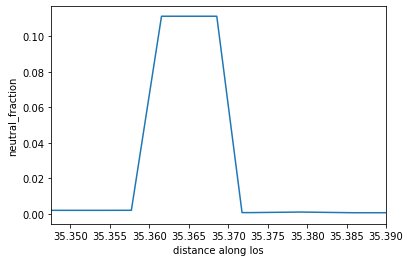

In [27]:
scale_to_mega_parsec = 0.1453*1000/0.68
plt.plot(distance,HI_density/gas_density)
plt.ylabel('neutral_fraction')
plt.xlabel('distance along los')
plt.xlim(35.34759, 35.39)

In [3]:
#extract typical distance
distance = 0 
for i in which:
    distance += i[2]-i[1]
distance/len(which)

0.026239385146804815

In [4]:
after = len(real_lyman)

In [5]:
after

2895

In [6]:
checkout = []
for i in real_area_under:
    checkout.append(i[-1])

In [7]:
import os
import numpy as np
from matplotlib import pyplot as plt      
import pandas as pd
from scipy import special                 
import array
import scipy as sp
import scipy.interpolate
import re
import pickle as pickle
from matplotlib.pyplot import figure
lyman_limited_value = []
for i in real_lyman:
        lyman_limited_value.append(i[0])

In [8]:
sigma = 6.3e-18
optical_depth = np.multiply(sigma,checkout)

In [9]:
import matplotlib.colors
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#002647","#0070c0","#faca21"])

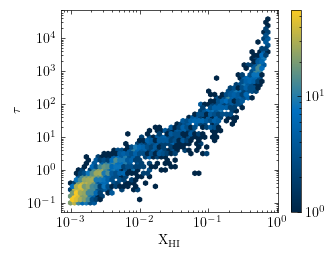

In [10]:
import matplotlib.pyplot as plt
with plt.style.context('science','notebook'):
    plt.xlabel("$\mathrm{X_{HI}}$",fontsize = 10)
    plt.ylabel(r"$\tau$",fontsize = 10)
    plt.xscale("log")
    plt.yscale("log")
    plt.hexbin(neutral_fraction,optical_depth,gridsize=50,bins='log',mincnt=1,xscale="log",yscale="log",cmap = cmap)
    plt.colorbar()
    plt.savefig('f4_non_uniform_cul_40_neutral_fraction.png') 

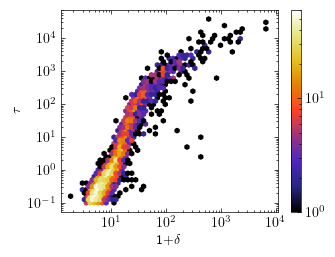

In [15]:
import matplotlib.pyplot as plt
with plt.style.context('science','notebook'):
    plt.xlabel("1+$\delta$",fontsize = 10)
    plt.ylabel(r"$\tau$",fontsize = 10)
    plt.xscale("log")
    plt.yscale("log")
    ##where the hack the critical gas density is calculated? 8.69e-28 change that   rho = 1.674e-24 g * nb
    plt.hexbin(np.multiply(gas_den,1.674e-24)/8.69e-28,optical_depth,gridsize=50,bins='log',mincnt=1,xscale="log",yscale="log",cmap ='CMRmap')
    plt.colorbar()
    plt.savefig('f4_non_uniform_40_1+delta.pdf') 

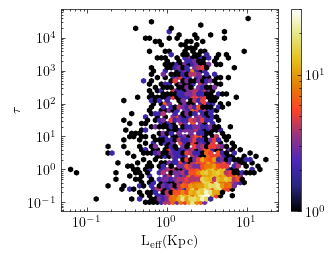

In [13]:
import matplotlib.pyplot as plt
with plt.style.context('science','notebook'):
    plt.xlabel("$\mathrm{L_{eff}(Kpc)}$",fontsize = 10)
    plt.ylabel(r"$\tau$",fontsize = 10)
    plt.xscale("log")
    plt.yscale("log")
    #first it is in cm, HI is number density
    plt.hexbin(np.multiply(np.divide(checkout,HI),3.24078e-22),optical_depth,gridsize=50,bins='log',mincnt=1,xscale="log",yscale="log",cmap ='CMRmap')
    plt.colorbar()
    plt.savefig('f4_non_uniform_40_L_eff.pdf') 

In [14]:
.026*

SyntaxError: invalid syntax (4204454634.py, line 1)

In [ ]:
import pickle as pickle

In [ ]:
with open('color_data0_cul_integral_high_neutral_fraction.pkl', 'rb') as f:
    color_data0 = pickle.load(f)

In [ ]:
color_data0

[[array([array([0.00000000e+00, 3.30892362e+18, 7.28379413e+18]),
         list([2.005363879937967, 12.166111410859045, 25.194943977006197])],
        dtype=object),
  1],
 [array([array([0.00000000e+00, 1.19423627e+17, 2.81225273e+17, 4.76322286e+17,
                6.73775652e+17, 7.12644710e+17, 7.42563656e+17, 7.81432714e+17]),
         list([27.40319811581587, 27.546867730618853, 24.59833160933951])],
        dtype=object),
  1],
 [array([array([0.00000000e+00, 1.41136534e+16, 2.10568778e+17, 6.33950686e+17,
                1.38784646e+18, 2.32500027e+18, 1.45266248e+19, 3.11355679e+19,
                3.45508273e+19, 4.62602879e+19, 5.82485453e+19, 6.91160769e+19,
                8.39676975e+19, 8.89308047e+19])                               ,
         list([7.394252207779161, 29.418341808233833, 25.468934346398903])],
        dtype=object),
  5],
 [array([array([0.00000000e+00, 5.27577223e+16, 1.32436337e+17]),
         list([38.98648723473044, 6.166193062854759, 33.113964501456

In [ ]:
with open('color_data1_cul_integral_high_neutral_fraction.pkl', 'rb') as f:
    color_data1 = pickle.load(f)

In [ ]:
len(color_data1)

710

In [ ]:
information = []
for i in color_data0:
    information.append([i[0][0][-1],i[1]])
for i in color_data1:
    information.append([i[0][0][-1],i[1]])

In [ ]:

start_to_end = np.linspace(16,22,7)
start_to_end

array([16., 17., 18., 19., 20., 21., 22.])

In [ ]:
for k in range(1,5):
    for i in range(0,6):
        total = 0
        count = 0
        for z in information:
            if(start_to_end[i]< np.log10(z[0]) < start_to_end[i+1]):
                total +=1
                if(z[1] <= k):
                    count+=1
        print(count/total)

0.24742268041237114
0.26605504587155965
0.4126984126984127
0.5392491467576792
0.71875
1.0
0.7371134020618557
0.7018348623853211
0.8
0.8088737201365188
0.93125
1.0
0.865979381443299
0.8967889908256881
0.9301587301587302
0.9180887372013652
0.99375
1.0
0.9381443298969072
0.9678899082568807
0.9777777777777777
0.9692832764505119
0.99375
1.0


In [ ]:
percentage = []
percentage.append(one)
percentage.append(two)
percentage.append(three)
percentage.append(four)

NameError: name 'one' is not defined

In [ ]:
percentage

[0.5657894736842105, 0.756578947368421, 0.8947368421052632, 0.9539473684210527]

In [ ]:

with open('percentage_16_17.pkl', 'rb') as f:
    percentage0 = pickle.load(f)
with open('percentage_17_18.pkl', 'rb') as f:
    percentage1 = pickle.load(f)
with open('percentage_18_19.pkl', 'rb') as f:
    percentage2 = pickle.load(f)
with open('percentage_19_20.pkl', 'rb') as f:
    percentage3 = pickle.load(f)
with open('percentage_20_21.pkl', 'rb') as f:
    percentage4 = pickle.load(f)
with open('percentage_21_22.pkl', 'rb') as f:
    percentage5 = pickle.load(f)

In [ ]:
i = 3
print(percentage0[i])
print(percentage1[i])
print(percentage2[i])
print(percentage3[i])
print(percentage4[i])
print(percentage5[i])

0.8609314359637775
0.9348370927318296
0.972972972972973
0.976027397260274
0.9877300613496932
1.0


In [ ]:
from scipy import integrate
import matplotlib.pyplot as plt
import os
import numpy as np
from matplotlib import pyplot as plt      
import pandas as pd
from scipy import special                 
import array
import scipy as sp
import scipy.interpolate
import re
import pickle as pickle

In [ ]:
within_one1 = [0.24742268041237114,
0.26605504587155965,
0.4126984126984127,
0.5392491467576792,
0.71875,
1.0,]
within_two1= [0.7371134020618557,
0.7018348623853211,
0.8,
0.8088737201365188,
0.93125,
1.0, ]
within_three1 = [0.865979381443299,
0.8967889908256881,
0.9301587301587302,
0.9180887372013652,
0.99375,
1.0,]
within_four1= [0.9381443298969072,
0.9678899082568807,
0.9777777777777777,
0.9692832764505119,
0.99375,
1.0, ]

In [ ]:
within_one = [0.10996119016817593,
0.19548872180451127,
0.3933933933933934,
0.5513698630136986,
0.7177914110429447,
1.0]

In [ ]:
within_two = [0.46248382923674,
0.6052631578947368,
0.7807807807807807,
0.821917808219178,
0.9263803680981595,
1.0]

In [ ]:
within_three = [0.7173350582147477,
0.8345864661654135,
0.924924924924925,
0.9212328767123288,
0.9877300613496932,
1.0]

In [ ]:
within_four = [0.8609314359637775,
0.9348370927318296,
0.972972972972973,
0.976027397260274,
0.9877300613496932,
1.0]

In [ ]:
x= np.linspace(16,21,6)

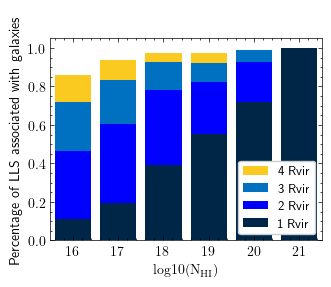

In [ ]:

with plt.style.context('science','notebook'):
    plt.bar(x,within_four,label = "4 Rvir",color = "#faca21")
    plt.bar(x,within_three,label = "3 Rvir",color ="#0070c0")
    plt.bar(x,within_two,label = "2 Rvir",color = "blue")
    plt.bar(x,within_one,label = "1 Rvir", color ='#002647')
    plt.xlabel("$\mathrm{log10(N_{HI})}$",fontsize = 10)
    plt.ylabel("Percentage of LLS associated with galaxies",fontsize =10)
    plt.ylim(0,1.05)
    plt.xlim(15.5,21.5)    
    plt.legend(frameon = True, facecolor='white', framealpha=1,fontsize = 9,loc = 'lower right' )
    plt.savefig("a_fvir.png")

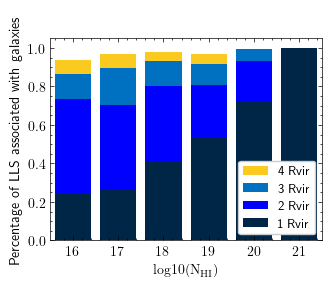

In [ ]:
with plt.style.context('science','notebook'):
    plt.bar(x,within_four1,label = "4 Rvir",color = "#faca21")
    plt.bar(x,within_three1,label = "3 Rvir",color ="#0070c0")
    plt.bar(x,within_two1,label = "2 Rvir",color = "blue")
    plt.bar(x,within_one1,label = "1 Rvir", color ='#002647')
    plt.xlabel("$\mathrm{log10(N_{HI})}$",fontsize = 10)
    plt.ylabel("Percentage of LLS associated with galaxies",fontsize =10)
    plt.ylim(0,1.05)
    plt.xlim(15.5,21.5)    
    plt.legend(frameon = True, facecolor='white', framealpha=1,fontsize = 9,loc = 'lower right' )
    plt.savefig("a_fvir.png")